In [1]:
### parameters
place = 'tel_aviv'
feature = 'sidewalk_width'

In [2]:
import pandas as pd
import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import MultiLineString, LineString, Point


from tqdm import tqdm
import numpy as np
import os
from pathlib import Path
import warnings
warnings.filterwarnings(action='ignore')
crs_prj = 'EPSG:2039'




# Get the current working directory (e.g., the folder you're running from)
cwd = Path().resolve()

# Get the parent directory
parent_folder = f'{cwd.parent}/places/{place}'
data_folder = f'{parent_folder}/shp'
os.makedirs(f'{parent_folder}',exist_ok=True)
os.makedirs(f'{parent_folder}/shp',exist_ok=True)
os.makedirs(f'{parent_folder}/shp/{feature}',exist_ok=True)
detail_folder = f'{data_folder}/{feature}'

In [6]:
streets = gpd.read_file(f'{data_folder}/streets.shp')
street_edges = streets.copy()
no_sidewalks = gpd.read_file(f'{detail_folder}/no_sidewalks.shp')
sidewalks = gpd.read_file(f'{detail_folder}/sidewalks.shp')

In [24]:


def create_perpendicular_line(point, direction_vector, length=30, side='left'):
    dx, dy = direction_vector
    mag = np.hypot(dx, dy)
    if mag == 0:
        return None
    dx /= mag
    dy /= mag

    # Rotate ±90° to get perpendicular direction
    perp_dx, perp_dy = (-dy, dx) if side == 'left' else (dy, -dx)
    end_point = Point(point.x + perp_dx * length, point.y + perp_dy * length)
    return LineString([point, end_point])

def get_point_and_direction(line, fraction):
    point = line.interpolate(fraction, normalized=True)
    # Estimate direction using a small delta on the line
    delta = 0.001
    p1 = line.interpolate(max(fraction - delta, 0), normalized=True)
    p2 = line.interpolate(min(fraction + delta, 1), normalized=True)
    direction = np.array([p2.x - p1.x, p2.y - p1.y])
    return point, direction

# Generate side lines
side_lines = []

for idx, row in street_edges.iterrows():
    geom = row.geometry

    if not isinstance(geom, LineString) or geom.length == 0:
        print(f'{idx} is not a valid street edge')
        continue

    # Get 1/3 and 2/3 points and direction vectors
    for loc,fraction in {'start' :1/3,'middle':0.5,'end': 2/3}.items():
        point, direction = get_point_and_direction(geom, fraction)
        for side in ['left', 'right']:
            line = create_perpendicular_line(point, direction, side=side)
            if line:
                side_lines.append({
                    'oidrechov': row['oidrechov'],
                    'side':f'{loc}_{side}',
                    'geometry': line,
                })

# Convert to GeoDataFrame and save
side_lines_gdf = GeoDataFrame(side_lines, crs=street_edges.crs)
side_lines_gdf.to_file(f'{detail_folder}/side_lines_gdf0.shp', driver='ESRI Shapefile')

# Ensure each perpendicular line has a unique index
side_lines_gdf = side_lines_gdf.reset_index(drop=True)

# Spatial join: find which perpendicular lines intersect which street edges
joined = gpd.sjoin(side_lines_gdf, GeoDataFrame(geometry= street_edges.geometry.buffer(0.005), crs=crs_prj), how='left', predicate='intersects')
joined['line_index'] = joined.index

# Count how many street segments each perpendicular line intersects
intersection_counts = (
    joined.groupby('line_index')
    .size()
    .reset_index(name='count')
)
# Merge counts back to original
side_lines_gdf = side_lines_gdf.merge(intersection_counts, left_index=True, right_on='line_index', how='left').drop(columns=['line_index'])
side_lines_gdf.to_file(f'{detail_folder}/side_lines_gdf1.shp', driver='ESRI Shapefile') 

In [26]:
side_lines_gdf['count'].value_counts()

In [67]:


# -------------------------------------------------------------------
# Helper: opposite side label (e.g. "middle_right" -> "middle_left")
# -------------------------------------------------------------------
def opposite_side_label(side_label: str) -> str | None:
    if "right" in side_label:
        return side_label.replace("right", "left")
    if "left" in side_label:
        return side_label.replace("left", "right")
    return None

# -------------------------------------------------------------------
# Helper: choose closest / farthest intersection for a line
# -------------------------------------------------------------------
def choose_intersection(group, sidewalks, start_point: Point, mode: str = "farthest"):
    """
    Select an intersection from `group` based on distance from `start_point`.

    Parameters
    ----------
    group : pandas.DataFrame
        Subset of `intersections` for a single line_id.
        Must contain column 'index_right'.
    sidewalks : GeoDataFrame
        Sidewalk geometries indexed so that sidewalks.loc[index_right] works.
    start_point : shapely.geometry.Point
        Start point of the side line geometry.
    mode : {'closest', 'farthest'}
        Whether to choose the closest or farthest sidewalk.

    Returns
    -------
    index_right value (scalar) or np.nan if group is empty.
    """
    if group.empty:
        return np.nan

    group = group.copy()

    # Fetch original sidewalk geometries using index_right
    group['sidewalk_geom'] = group['index_right'].apply(
        lambda idx: sidewalks.loc[idx, 'geometry']
    )
    # Compute distance from start point to each sidewalk
    group['dist'] = group['sidewalk_geom'].apply(
        lambda g: g.distance(start_point)
    )

    ascending = (mode == "closest")
    chosen = group.sort_values('dist', ascending=ascending).iloc[0]
    return chosen['index_right']


# ============================================================
# Main logic
# ============================================================

# Step 0: precompute start point for each side line (efficiency)
side_lines_gdf = side_lines_gdf.copy()
side_lines_gdf['start_point'] = side_lines_gdf.geometry.apply(
    lambda geom: Point(geom.coords[0])
)

# Get all unique side labels from the 'side' column
side_keys = side_lines_gdf['side'].unique()

# Step 1: Spatial join between side lines and sidewalks
from shapely.ops import nearest_points

# Spatial join: which sidewalk each perpendicular line intersects
intersections = gpd.sjoin(
    side_lines_gdf,
    sidewalks,
    how='left'
).drop(columns=['Layer'])

def compute_intersection_point(row):
    line = row.geometry
    idx = row['index_right']
    if pd.isna(idx):
        return None
    sidewalk_geom = sidewalks.loc[idx, 'geometry']
    inter = line.intersection(sidewalk_geom)
    start_pt = row['start_point']

    if inter.geom_type == 'MultiPoint':
        # choose the point closest to the start point
        points = list(inter.geoms)
        inter = min(points, key=lambda p: p.distance(start_pt))

    return inter


# Add the intersection point column
intersections['intersection_point'] = intersections.apply(
    compute_intersection_point, axis=1
)

# Step 2: Group intersections by line index
grouped = intersections.groupby(intersections.index)

# Step 3: Initialize results dictionary
side_line_results = {}

# Step 4: Process each side line
for line_id, group in grouped:
    line_row = side_lines_gdf.loc[line_id]
    side_label = line_row['side']
    oid = line_row['oidrechov']
    start_point = line_row['start_point']

    # Default result
    res = -1

    if len(group) == 1:
        # Single intersection – check if its index_right is NaN
        idx = group.iloc[0]['index_right']

        if not pd.isna(idx):
            # Simple case: one valid intersection
            res = idx
        else:
            # idx is NaN → fallback to opposite side
            opp_side = opposite_side_label(side_label)
            if opp_side is not None:
                # Find opposite side line with same oidrechov
                opp_match = side_lines_gdf[
                    (side_lines_gdf['oidrechov'] == oid) &
                    (side_lines_gdf['side'] == opp_side)
                ]

                if not opp_match.empty:
                    opp_line_id = opp_match.index[0]

                    # Only proceed if we have intersections for opposite line
                    if opp_line_id in grouped.groups:
                        opp_group = grouped.get_group(opp_line_id)

                        # Based on your description:
                        #   - If len(opp_group) == 1 → do nothing (keep res = 0)
                        #   - If len(opp_group) > 1 → choose the CLOSEST one
                        if len(opp_group) > 1:
                            opp_line_row = side_lines_gdf.loc[opp_line_id]
                            opp_start = opp_line_row['start_point']
                            res = choose_intersection(
                                opp_group,
                                sidewalks,
                                opp_start,
                                mode="closest"
                            )
                        # else: len == 1 → do nothing, res stays 0

    else:
        # Multiple intersections on this side – choose the FARTHEST from the start
        res = choose_intersection(
            group,
            sidewalks,
            start_point,
            mode="farthest"
        )

    # Initialize entry if oid not in results
    if oid not in side_line_results:
        side_line_results[oid] = {key: None for key in side_keys}
        side_line_results[oid]['geometry'] = street_edges.loc[
            street_edges['oidrechov'] == oid, 'geometry'
        ].iloc[0]

    # Store result (0 if res is None / NaN)
    side_line_results[oid][side_label] = float(res) if res is not None and not pd.isna(res) else -1

# Step 5: Convert results to GeoDataFrame
records = []
for oid, values in side_line_results.items():
    record = {'oidrechov': oid, 'geometry': values['geometry']}
    for key in side_keys:
        record[key] = values.get(key)
    records.append(record)

gdf = GeoDataFrame(records, crs=crs_prj)
gdf.to_file(f'{detail_folder}/streets_sidewalks_mid.shp', driver='ESRI Shapefile')




In [ ]:
# Test - Start

In [68]:
intersections

,oidrechov,side,geometry,count,start_point,index_right,intersection_point
0,1.0,start_left,"LINESTRING (184332.382 668569.389, 184346.356 ...",1,POINT (184332.382 668569.389),9159.0,POINT (184333.38 668571.286)
1,1.0,start_right,"LINESTRING (184332.382 668569.389, 184318.408 ...",1,POINT (184332.382 668569.389),9229.0,POINT (184328.616 668562.235)
2,1.0,middle_left,"LINESTRING (184337.22 668566.842, 184351.195 6...",1,POINT (184337.22 668566.842),9159.0,POINT (184337.838 668568.014)
3,1.0,middle_right,"LINESTRING (184337.22 668566.842, 184323.246 6...",1,POINT (184337.22 668566.842),9229.0,POINT (184333.076 668558.969)
4,1.0,end_left,"LINESTRING (184342.059 668564.295, 184356.033 ...",1,POINT (184342.059 668564.295),9159.0,POINT (184342.682 668565.479)
...,...,...,...,...,...,...,...
52501,9640.0,start_right,"LINESTRING (178809.769 665067.331, 178831.986 ...",1,POINT (178809.769 665067.331),NaN,None
52502,9640.0,middle_left,"LINESTRING (178813.567 665071.516, 178791.349 ...",1,POINT (178813.567 665071.516),NaN,None
52503,9640.0,middle_right,"LINESTRING (178813.567 665071.516, 178835.784 ...",1,POINT (178813.567 665071.516),11324.0,POINT (178817.9 665067.583)
52504,9640.0,end_left,"LINESTRING (178817.897 665075.079, 178801.372 ...",1,POINT (178817.897 665075.079),NaN,None


In [63]:
from shapely.ops import nearest_points

# Spatial join: which sidewalk each perpendicular line intersects
intersections = gpd.sjoin(
    side_lines_gdf,
    sidewalks,
    how='left'
).drop(columns=['Layer'])

def compute_intersection_point(row):
    line = row.geometry
    idx = row['index_right']
    if pd.isna(idx):
        return None
    sidewalk_geom = sidewalks.loc[idx, 'geometry']
    inter = line.intersection(sidewalk_geom)
    start_pt = row['start_point']

    if inter.geom_type == 'MultiPoint':
        # choose the point closest to the start point
        points = list(inter.geoms)
        inter = min(points, key=lambda p: p.distance(start_pt))

    return inter


# Add the intersection point column
intersections['intersection_point'] = intersections.apply(
    compute_intersection_point, axis=1
)


9159.0
9229.0
9159.0
9229.0
9159.0
9229.0
8876.0
9159.0
8876.0
9159.0
8876.0
9159.0
9229.0
8880.0
9229.0
8880.0
9229.0
8880.0
9159.0
9159.0
9159.0
9229.0
9229.0
9229.0
10878.0
10531.0
10531.0
10533.0
10531.0
10533.0
10862.0
10920.0
10862.0
10920.0
10862.0
10920.0
10876.0
10919.0
10876.0
10919.0
10876.0
10919.0
10520.0
10485.0
10520.0
10486.0
10520.0
10486.0
10872.0
10886.0
10872.0
10886.0
10872.0
10886.0
10530.0
10518.0
10530.0
10518.0
10530.0
10518.0
33857.0
33855.0
33852.0
33820.0
33857.0
33855.0
33852.0
33820.0
33857.0
33855.0
33852.0
33820.0
33854.0
33857.0
33852.0
33854.0
33857.0
33852.0
33854.0
33857.0
33852.0
34036.0
34036.0
34036.0
34030.0
34029.0
34036.0
34023.0
34033.0
34031.0
34029.0
34036.0
34034.0
34030.0
34088.0
34059.0
34053.0
34054.0
34055.0
34016.0
34061.0
34088.0
34059.0
35418.0
35428.0
35418.0
35428.0
35418.0
35428.0
35418.0
35423.0
35418.0
35423.0
35418.0
35423.0
35423.0
35428.0
35423.0
35428.0
35423.0
35428.0
35899.0
35890.0
35899.0
35890.0
35899.0
35890.0
35428.0


In [66]:
intersections.set_index('oidrechov').loc[3901]

,side,geometry,count,start_point,index_right,intersection_point
oidrechov,,,,,,
3901.0,start_left,"LINESTRING (176610.895 662190.232, 176601.901 ...",1,POINT (176610.895 662190.232),26778.0,POINT (176604.744 662170.657)
3901.0,start_right,"LINESTRING (176610.895 662190.232, 176619.889 ...",1,POINT (176610.895 662190.232),NaN,None
3901.0,middle_left,"LINESTRING (176599.186 662193.912, 176590.192 ...",1,POINT (176599.186 662193.912),26778.0,POINT (176593.241 662174.997)
3901.0,middle_right,"LINESTRING (176599.186 662193.912, 176608.179 ...",1,POINT (176599.186 662193.912),NaN,None
3901.0,end_left,"LINESTRING (176587.476 662197.592, 176578.482 ...",1,POINT (176587.476 662197.592),26778.0,POINT (176581.456 662178.435)
3901.0,end_right,"LINESTRING (176587.476 662197.592, 176596.47 6...",1,POINT (176587.476 662197.592),NaN,None


In [57]:
# Step 1: Spatial join between side lines and sidewalks
intersections = gpd.sjoin(side_lines_gdf, sidewalks, how='left').drop(columns=['Layer'])
intersections

,oidrechov,side,geometry,count,start_point,index_right
0,1.0,start_left,"LINESTRING (184332.382 668569.389, 184346.356 ...",1,POINT (184332.382 668569.389),9159.0
1,1.0,start_right,"LINESTRING (184332.382 668569.389, 184318.408 ...",1,POINT (184332.382 668569.389),9229.0
2,1.0,middle_left,"LINESTRING (184337.22 668566.842, 184351.195 6...",1,POINT (184337.22 668566.842),9159.0
3,1.0,middle_right,"LINESTRING (184337.22 668566.842, 184323.246 6...",1,POINT (184337.22 668566.842),9229.0
4,1.0,end_left,"LINESTRING (184342.059 668564.295, 184356.033 ...",1,POINT (184342.059 668564.295),9159.0
...,...,...,...,...,...,...
52501,9640.0,start_right,"LINESTRING (178809.769 665067.331, 178831.986 ...",1,POINT (178809.769 665067.331),NaN
52502,9640.0,middle_left,"LINESTRING (178813.567 665071.516, 178791.349 ...",1,POINT (178813.567 665071.516),NaN
52503,9640.0,middle_right,"LINESTRING (178813.567 665071.516, 178835.784 ...",1,POINT (178813.567 665071.516),11324.0
52504,9640.0,end_left,"LINESTRING (178817.897 665075.079, 178801.372 ...",1,POINT (178817.897 665075.079),NaN


In [ ]:
# Test - End

In [71]:

# Extend line by 50m and buffer 1m
def extend_and_buffer(line, length=50, buffer_dist=1):
    if not isinstance(line, LineString) or len(line.coords) < 2:
        print('error in the geometry of the line')
        return None
    start, end = line.coords[0], line.coords[-1]
    dx, dy = end[0] - start[0], end[1] - start[1]
    norm = (dx**2 + dy**2) ** 0.5
    if norm == 0:
        return None
    dx /= norm
    dy /= norm
    new_end = (start[0] + dx * length, start[1] + dy * length)
    extended = LineString([start, new_end])
    return extended.buffer(buffer_dist)

# Apply to all perpendicular lines
buffered_perp_lines = intersections.copy()
buffered_perp_lines['geometry'] = buffered_perp_lines['geometry'].apply(extend_and_buffer)
buffered_perp_lines = buffered_perp_lines.dropna(subset=['geometry']).drop(columns =['start_point','index_right'])
buffered_perp_lines.drop(columns =['intersection_point']).to_file(f'{detail_folder}/extended_line.shp', driver='ESRI Shapefile')
intersections_1 = gpd.sjoin(buffered_perp_lines, no_sidewalks)

intersections_1['no_sidewalk_geom'] = intersections_1['index_right'].apply(lambda idx: no_sidewalks.loc[idx, 'geometry'])
intersections_1

,oidrechov,side,geometry,count,intersection_point,index_right,Layer,no_sidewalk_geom
0,1.0,start_left,"POLYGON ((184354.787 668614.099, 184354.837 66...",1,POINT (184333.38 668571.286),75697,2408,LINESTRING (184326.96556980125 668577.86478243...
0,1.0,start_left,"POLYGON ((184354.787 668614.099, 184354.837 66...",1,POINT (184333.38 668571.286),79202,2207,LINESTRING (184344.63548222833 668584.64606367...
0,1.0,start_left,"POLYGON ((184354.787 668614.099, 184354.837 66...",1,POINT (184333.38 668571.286),63810,2601,LINESTRING (184341.47524509308 668587.03585642...
0,1.0,start_left,"POLYGON ((184354.787 668614.099, 184354.837 66...",1,POINT (184333.38 668571.286),63807,2601,LINESTRING (184346.97567538076 668582.62621562...
0,1.0,start_left,"POLYGON ((184354.787 668614.099, 184354.837 66...",1,POINT (184333.38 668571.286),78212,2200,LINESTRING (184358.50428215906 668606.08716727...
...,...,...,...,...,...,...,...,...
52504,9640.0,end_left,"POLYGON ((178789.521 665116.259, 178789.471 66...",1,None,96597,2602,LINESTRING (178812.73394566122 665106.80704960...
52504,9640.0,end_left,"POLYGON ((178789.521 665116.259, 178789.471 66...",1,None,105651,2200,LINESTRING (178792.09105272958 665075.89221734...
52504,9640.0,end_left,"POLYGON ((178789.521 665116.259, 178789.471 66...",1,None,98501,2602,LINESTRING (178785.3428569584 665111.725158445...
52505,9640.0,end_right,"POLYGON ((178846.273 665033.899, 178846.323 66...",1,POINT (178817.905 665075.067),96597,2602,LINESTRING (178812.73394566122 665106.80704960...


In [ ]:
REMOVE THE NUN

In [56]:
side_lines_gdf

,oidrechov,side,geometry,count,start_point
0,1.0,start_left,"LINESTRING (184332.382 668569.389, 184346.356 ...",1,POINT (184332.382 668569.389)
1,1.0,start_right,"LINESTRING (184332.382 668569.389, 184318.408 ...",1,POINT (184332.382 668569.389)
2,1.0,middle_left,"LINESTRING (184337.22 668566.842, 184351.195 6...",1,POINT (184337.22 668566.842)
3,1.0,middle_right,"LINESTRING (184337.22 668566.842, 184323.246 6...",1,POINT (184337.22 668566.842)
4,1.0,end_left,"LINESTRING (184342.059 668564.295, 184356.033 ...",1,POINT (184342.059 668564.295)
...,...,...,...,...,...
52501,9640.0,start_right,"LINESTRING (178809.769 665067.331, 178831.986 ...",1,POINT (178809.769 665067.331)
52502,9640.0,middle_left,"LINESTRING (178813.567 665071.516, 178791.349 ...",1,POINT (178813.567 665071.516)
52503,9640.0,middle_right,"LINESTRING (178813.567 665071.516, 178835.784 ...",1,POINT (178813.567 665071.516)
52504,9640.0,end_left,"LINESTRING (178817.897 665075.079, 178801.372 ...",1,POINT (178817.897 665075.079)


In [54]:
gdf

,oidrechov,geometry,start_left,start_right,middle_left,middle_right,end_left,end_right
0,1.0,"LINESTRING (184322.705 668574.483, 184351.736 ...",9159.0,9229.0,9159.0,9229.0,9159.0,9229.0
1,320.0,"LINESTRING (184251.346 668628.811, 184322.705 ...",9159.0,8876.0,9159.0,8876.0,9159.0,8876.0
2,9429.0,"LINESTRING (184322.705 668574.483, 184297.349 ...",9229.0,8880.0,9229.0,8880.0,9229.0,8880.0
3,423.0,"LINESTRING (184351.736 668559.201, 184381.018 ...",9159.0,-1.0,9159.0,-1.0,9159.0,-1.0
4,9427.0,"LINESTRING (184351.736 668559.201, 184371.851 ...",-1.0,9229.0,-1.0,9229.0,-1.0,9229.0
...,...,...,...,...,...,...,...,...
8746,9638.0,"LINESTRING (178863.057 665070.191, 178854.901 ...",-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
8747,9643.0,"LINESTRING (178841.446 665011.389, 178853.393 ...",-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
8748,9639.0,"LINESTRING (178810.907 665023.311, 178806.881 ...",-1.0,11270.0,-1.0,-1.0,-1.0,-1.0
8749,9642.0,"LINESTRING (178841.446 665011.389, 178835.182 ...",-1.0,12516.0,-1.0,-1.0,-1.0,-1.0


In [26]:

side_fields = side_keys
side_fields_w = [side + '_w' for side in side_keys ]

gdf_widths = gdf.copy()

for side in side_fields:
    gdf_widths[side_fields_w ] = -1.0  # init with -1

# Pre-index: {(oid, side) → line geometry}
line_geom_lookup = {
    (row['oidrechov'], row['side']): row.geometry
    for idx, row in side_lines_gdf.iterrows()
}

# Pre-index: {(oid, side) → intersection GeoDataFrame}
intersection_groups = dict(tuple(intersections.groupby(['oidrechov', 'side'])))



# Process efficiently
for idx, row in tqdm(gdf.iterrows(), total=len(gdf), desc="Processing widths"):
    oid = row['oidrechov']
    values = [row[f] for f in side_fields]

    # Fast logic for all 0/-1 cases
    if all((v == 0) or (v == -1) for v in values):
        result_value = 0 if any(v == 0 for v in values) else -1
        for side in side_fields:
            gdf_widths.at[idx, f'{side}_w'] = result_value
        continue

    for side in side_fields:
        sid = row[side]
        if sid in [-1, 0]:
            continue

        # Lookup intersections
        group_key = (oid, side)
        if group_key not in intersection_groups:
            gdf_widths.at[idx, f'{side}_w'] = -1
            continue

        matching = intersection_groups[group_key]

        # Lookup line geometry
        line_geom = line_geom_lookup.get(group_key)
        if line_geom is None or line_geom.is_empty:
            gdf_widths.at[idx, f'{side}_w'] = -1
            continue

        start_point = Point(line_geom.coords[0])

        # Compute distances only once using vectorized apply
        matching = matching.copy()
        matching['dist_to_start'] = matching['no_sidewalk_geom'].apply(lambda g: g.distance(start_point))
        closest = matching.sort_values('dist_to_start').iloc[0]['no_sidewalk_geom']

        # Distance to sidewalk (true width)
        dist = sidewalks.loc[sid].geometry.distance(closest)
        gdf_widths.at[idx, f'{side}_w'] = dist

gdf_widths.to_file(f'{detail_folder}/gdf_widths.shp', driver='ESRI Shapefile')


Processing widths: 100%|██████████| 8751/8751 [01:22<00:00, 105.71it/s]


In [ ]:
# test - Start

In [53]:
gdf

,oidrechov,geometry,start_left,start_right,middle_left,middle_right,end_left,end_right
0,1.0,"LINESTRING (184322.705 668574.483, 184351.736 ...",9159.0,9229.0,9159.0,9229.0,9159.0,9229.0
1,320.0,"LINESTRING (184251.346 668628.811, 184322.705 ...",9159.0,8876.0,9159.0,8876.0,9159.0,8876.0
2,9429.0,"LINESTRING (184322.705 668574.483, 184297.349 ...",9229.0,8880.0,9229.0,8880.0,9229.0,8880.0
3,423.0,"LINESTRING (184351.736 668559.201, 184381.018 ...",9159.0,-1.0,9159.0,-1.0,9159.0,-1.0
4,9427.0,"LINESTRING (184351.736 668559.201, 184371.851 ...",-1.0,9229.0,-1.0,9229.0,-1.0,9229.0
...,...,...,...,...,...,...,...,...
8746,9638.0,"LINESTRING (178863.057 665070.191, 178854.901 ...",-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
8747,9643.0,"LINESTRING (178841.446 665011.389, 178853.393 ...",-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
8748,9639.0,"LINESTRING (178810.907 665023.311, 178806.881 ...",-1.0,11270.0,-1.0,-1.0,-1.0,-1.0
8749,9642.0,"LINESTRING (178841.446 665011.389, 178835.182 ...",-1.0,12516.0,-1.0,-1.0,-1.0,-1.0


In [31]:

gdf.loc[5170]

oidrechov                                                  3901.0
geometry        LINESTRING (176634.314 662182.873, 176564.0569...
start_left                                                26778.0
start_right                                                  -1.0
middle_left                                               26778.0
middle_right                                                 -1.0
end_left                                                  26778.0
end_right                                                    -1.0
Name: 5170, dtype: object

In [ ]:
idx = 5170
row= gdf.loc[idx]
oid = row['oidrechov']
values = [row[f] for f in side_fields]
all((v == 0) or (v == -1) for v in values)
row

In [46]:
side = 'start_left'
sid = row[side]
group_key = (oid, side)
matching = intersection_groups[group_key]
        # Lookup intersections
group_key = (oid, side)
# Lookup line geometry
line_geom = line_geom_lookup.get(group_key)
line_geom is None or line_geom.is_empty

False

In [50]:

start_point = Point(line_geom.coords[0])
print(start_point)

POINT (176610.895 662190.2323333333)


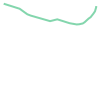

In [47]:
# Compute distances only once using vectorized apply
matching = matching.copy()
matching['dist_to_start'] = matching['no_sidewalk_geom'].apply(lambda g: g.distance(start_point))
closest = matching.sort_values('dist_to_start').iloc[0]['no_sidewalk_geom']
closest

In [48]:
matching.sort_values('dist_to_start').iloc[0]

oidrechov                                                      3901.0
side                                                       start_left
geometry            POLYGON ((176602.85523406861 662161.312406574,...
count                                                               1
index_right                                                    201148
Layer                                                            2409
no_sidewalk_geom    LINESTRING (176577.01461520494 662197.56300647...
dist_to_start                                                1.282273
Name: 31020, dtype: object

KeyError: (np.float64(3901.0), np.float64(26778.0))

In [ ]:

    # Fast logic for all 0/-1 cases
    if all((v == 0) or (v == -1) for v in values):
        result_value = 0 if any(v == 0 for v in values) else -1
        for side in side_fields:
            gdf_widths.at[idx, f'{side}_w'] = result_value
        continue

    for side in side_fields:
        sid = row[side]
        if sid in [-1, 0]:
            continue

        # Lookup intersections
        group_key = (oid, side)
        if group_key not in intersection_groups:
            gdf_widths.at[idx, f'{side}_w'] = -1
            continue

        matching = intersection_groups[group_key]

        # Lookup line geometry
        line_geom = line_geom_lookup.get(group_key)
        if line_geom is None or line_geom.is_empty:
            gdf_widths.at[idx, f'{side}_w'] = -1
            continue

        start_point = Point(line_geom.coords[0])

        # Compute distances only once using vectorized apply
        matching = matching.copy()
        matching['dist_to_start'] = matching['no_sidewalk_geom'].apply(lambda g: g.distance(start_point))
        closest = matching.sort_values('dist_to_start').iloc[0]['no_sidewalk_geom']

        # Distance to sidewalk (true width)
        dist = sidewalks.loc[sid].geometry.distance(closest)
        gdf_widths.at[idx, f'{side}_w'] = dist


In [19]:
buffered_perp_lines

,oidrechov,side,geometry,count,start_point
0,1.0,start_left,"POLYGON ((184345.471 668596.401, 184345.521 66...",1,POINT (184332.382 668569.389)
1,1.0,start_right,"POLYGON ((184319.293 668542.377, 184319.243 66...",2,POINT (184332.382 668569.389)
2,1.0,middle_left,"POLYGON ((184350.31 668593.854, 184350.36 6685...",1,POINT (184337.22 668566.842)
3,1.0,middle_right,"POLYGON ((184324.131 668539.83, 184324.081 668...",2,POINT (184337.22 668566.842)
4,1.0,end_left,"POLYGON ((184355.148 668591.307, 184355.198 66...",1,POINT (184342.059 668564.295)
...,...,...,...,...,...
52501,9640.0,start_right,"POLYGON ((178832.658 665047.912, 178832.728 66...",1,POINT (178809.769 665067.331)
52502,9640.0,middle_left,"POLYGON ((178790.677 665090.934, 178790.608 66...",1,POINT (178813.567 665071.516)
52503,9640.0,middle_right,"POLYGON ((178836.456 665052.097, 178836.525 66...",1,POINT (178813.567 665071.516)
52504,9640.0,end_left,"POLYGON ((178800.537 665099.566, 178800.488 66...",1,POINT (178817.897 665075.079)


In [ ]:
# Test -  END

In [27]:


# Define left and right _w fields
left_fields = [f for f in gdf_widths.columns if f.endswith('_left_w')]
right_fields = [f for f in gdf_widths.columns if f.endswith('_right_w')]

def compute_side_final(values):
    values = [v for v in values if v != -1]
    if len(values) == 0:
        return -1
    if len(values) == 1:
        return values[0]
    if len(values) == 2:
        a, b = values
    else:
        # Pick two closest values
        values = sorted(values)
        best_pair = min(((a, b) for i, a in enumerate(values) for b in values[i+1:]), key=lambda x: abs(x[0] - x[1]))
        a, b = best_pair
    if abs(a - b) > 10:
        return min(a, b)
    return (a + b) / 2

# Apply to each row
def compute_final_columns(row):
    left_values = [row[f] for f in left_fields]
    right_values = [row[f] for f in right_fields]
    final_left = compute_side_final(left_values)
    final_right = compute_side_final(right_values)

    # Compute final
    if final_left == -1 and final_right == -1:
        final = -1
    elif final_left == -1:
        final = final_right
    elif final_right == -1:
        final = final_left
    else:
        final = (final_left + final_right) / 2
    return pd.Series({'final_left': final_left, 'final_right': final_right, 'final': final})

# Apply across DataFrame
gdf_widths[['final_left', 'final_right', 'final']] = gdf_widths.apply(compute_final_columns, axis=1)
gdf_widths.to_file(f'{detail_folder}/{feature}.shp',driver='ESRI Shapefile')

In [42]:
### THis code is for selecting sidewalks form my raw data - I don"t need to run it only for the first time:   ###
# -----------------------------------------------------------------------------
# Step 1: Read the 'translation' layer from a File Geodatabase
# -----------------------------------------------------------------------------
# This loads only the 'geometry' and 'Layer' columns from the specified layer
# within the ESRI File Geodatabase located at 'ASC/ASC.gdb'.
gdf = gpd.read_file('ASC/ASC.gdb', layer="translation")[['geometry', 'Layer']]

# -----------------------------------------------------------------------------
# Step 2: Define a function to drop the Z dimension from 3D MultiLineStrings
# -----------------------------------------------------------------------------
# This function takes a MultiLineString Z geometry and converts it to a
# 2D MultiLineString by removing the Z (elevation) component from each point.
# It assumes that the input is either a MultiLineString Z or already 2D.
def drop_z(geom):
    # Check if the geometry has a Z dimension
    if geom.has_z:
        # Rebuild each LineString within the MultiLineString, dropping the Z value
        return MultiLineString([
            LineString([(x, y) for x, y, z in line.coords])  # keep only X and Y
            for line in geom.geoms  # iterate over individual LineStrings
        ])
    else:
        # If the geometry is already 2D, return it unchanged
        return geom

# -----------------------------------------------------------------------------
# Step 3: Apply the drop_z function to each geometry in the GeoDataFrame
# -----------------------------------------------------------------------------
# This transforms the entire geometry column to 2D by removing Z values.
# The result is still a valid GeoDataFrame with MultiLineString geometries.
gdf['geometry'] = gdf['geometry'].apply(drop_z)
gdf = gdf.to_crs(crs_prj)
# -----------------------------------------------------------------------------
# Step 6: Export the translated geometries to a new shapefile
# -----------------------------------------------------------------------------
# The resulting GeoDataFrame is saved as a new shapefile named 'translation2.shp'
# in the 'files' directory. All attributes are preserved.
gdf.to_file(f'{data_folder}/itm_data.shp')

### YOU DONT NEED TO RUN THIS CELL ###
# -----------------------------------------------------------------------------
# Step 1: Filter sidewalk and non-sidewalk features based on the 'Layer' field
# -----------------------------------------------------------------------------
# Sidewalks are identified where 'Layer' == '2404'
# All other features are treated as non-sidewalks
sidewalks = gdf[gdf['Layer'] == '2404']
no_sidewalk = gdf[~(gdf['Layer'] == '2404')]
sidewalks.to_file(f'{data_folder}/sidewalks.shp')
### YOU DONT NEED TO RUN THIS CELL ###
# Optional: Save non-sidewalk features to a shapefile for inspection or use
no_sidewalk.to_file(f'{data_folder}/no_sidewalk.shp')